In [2]:
import os
from pathlib import Path
from time import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn-colorblind')

import astropy.units as u
from astropy.io import fits
from astropy.modeling import models, fitting

from spectral_cube import SpectralCube

# Uncomment to create a progress bar for all dask operations.
# Disabled here as it increases the run time significantly for this small cube.
# from dask.diagnostics import ProgressBar
# pbar = ProgressBar()
# pbar.register()

In [3]:
filename = 'member.uid___A001_X3621_X1a6a.N159-13CII_sci.spw26.cube.I.pbcor.fits'
cube = SpectralCube.read(filename, format='fits', use_dask=True)

# Convert to km/s for the spectral unit
#cube = cube.with_spectral_unit(u.km / u.s)

t0 = time() 

out = cube.statistics()
t1 = time()

time_cubestats = t1 - t0 #mide el tiempo de ejecucion
print(f'Cube statistics time: {time_cubestats} s')
print(f'Cube statistics: {out}')


Cube statistics time: 0.6757915019989014 s
Cube statistics: {'npts': np.float64(14989491.0), 'min': <Quantity -0.1138537 Jy / beam>, 'max': <Quantity 0.11928345 Jy / beam>, 'sum': <Quantity -72.60558319 Jy / beam>, 'sumsq': <Quantity 2259.77270508 Jy2 / beam2>, 'mean': <Quantity -4.84376576e-06 Jy / beam>, 'sigma': <Quantity 0.01227832 Jy / beam>, 'rms': <Quantity 0.01227832 Jy / beam>}


In [5]:
print(f"Number of beams: {len(cube)}")
print(cube.beam)

Number of beams: 2043
Beam: BMAJ=15.9921123122052 arcsec BMIN=11.6163975211884 arcsec BPA=-85.5068698214 deg


## Moment maps ##

Moment maps are a common method used to analyze the signal in a spectral-line data cube. Typically, the first few moments calculated along the spectral dimensions have the information required for most analyses. These are defined as:

* Moment 0: The integrated intensity in each spectrum. The units are the cube's brightness units multiplied by the spectral unit (e.g., K km/s).
* Moment 1: The intensity weighted centroid along a spectrum. The units are in the spectral dimension in the cube (e.g., km/s or GHz).
* Moment 2: The intensity weighted dispersion along a spectrum. The square root estimates the line width. The units are in the spectral dimension in the cube (e.g., km/s or GHz).
* Peak intensity: The maximum in each spectrum. The units are the dimensions of the cube (e.g., K or Jy/beam)
* Peak velocity: The spectral position of the maximum along a spectrum (i.e., the peak of a spectrum). The units are in the spectral dimension in the cube.

for this, i will use the following link of guide: https://colab.research.google.com/github/radio-astro-tools/tutorials/blob/master/casa_to_spectralcube_guide/casa_to_spectralcube_guide.ipynb#scrollTo=g1KIb0uYU1VU


### Moment 0 ###
In spectral-cube, there is a generic `SpectralCube.moment` function, and a separate `SpectralCube.moment0` function for convenience. The former just requires specifying the order of the moment.

In [15]:
t0 = time()

moment0 = cube.moment(order=0)
t1 = time()

time_moment0 = t1 - t0
print(f'Moment 0 time: {time_moment0} s')
print(moment0.unit)


Moment 0 time: 0.675931453704834 s
Hz Jy / beam


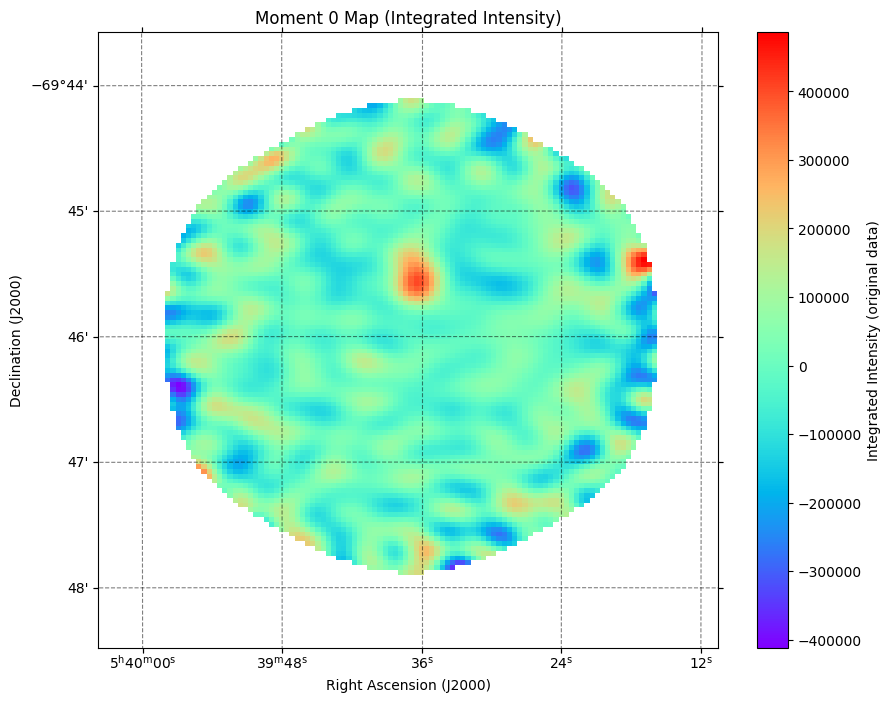

In [16]:
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord

header = cube.wcs.to_header()
wcs = cube.wcs.celestial

plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)  # Usar WCS para los ejes
im = ax.imshow(moment0.value, origin='lower', cmap='rainbow', aspect='auto')
plt.colorbar(im, label="Integrated Intensity (original data)")
ax.set_xlabel("Right Ascension (J2000)")
ax.set_ylabel("Declination (J2000)")
plt.title("Moment 0 Map (Integrated Intensity)")
plt.grid(color='black', linestyle='--', alpha=0.5)
plt.show()



### A note on masking ###

With increasing order, the moment maps become more susceptible to noise in the cube. Because of this, it becomes necessary to impose a signal mask to exclude regions without signal from the moment maps.



In [17]:
sigma = 0.01227832
umbral = sigma * 5

moment0_value = moment0.value
Spatial_mask = moment0_value > umbral 

Masked_Cube = cube.with_mask(Spatial_mask)

### Moment 1 ###

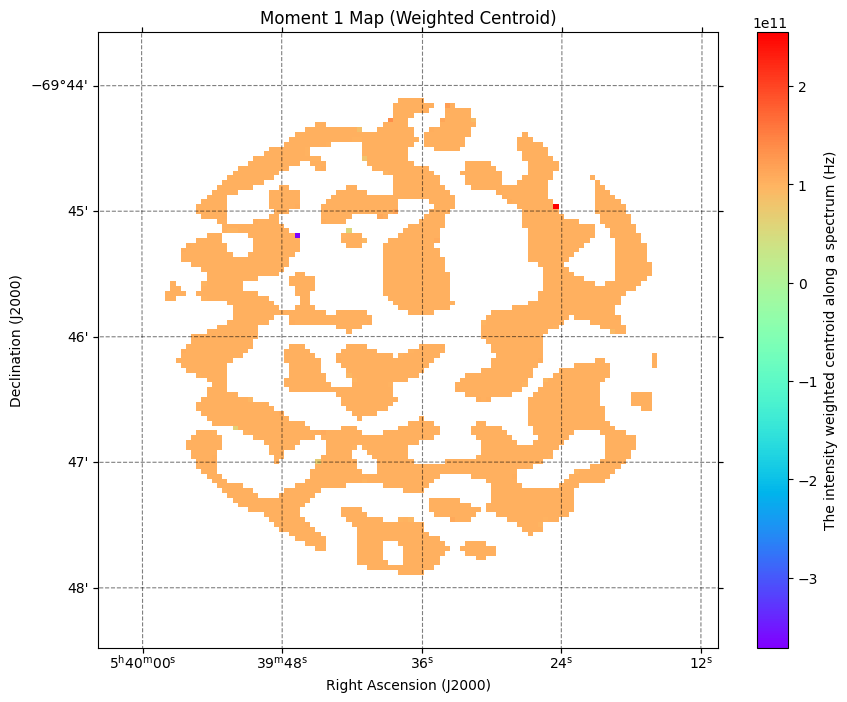

In [21]:
moment1 = Masked_Cube.moment(order=1)

plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)  # Usar WCS para los ejes
im = ax.imshow(moment1.value, origin='lower', cmap='rainbow', aspect='auto')
plt.colorbar(im, label="The intensity weighted centroid along a spectrum (Hz)")
ax.set_xlabel("Right Ascension (J2000)")
ax.set_ylabel("Declination (J2000)")
plt.title("Moment 1 Map (Weighted Centroid)")
plt.grid(color='black', linestyle='--', alpha=0.5)
plt.show()

### Moment 2 and line width ###

The second moment map is the variance. Because of this, we are usually intrested in its square root---effectively the standard deviation. For a Gaussian line profile with very high signal-to-noise ratio, this standard deviation will be the line of the Gaussian.

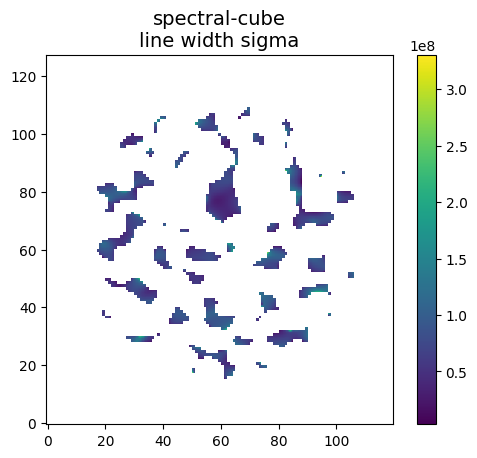

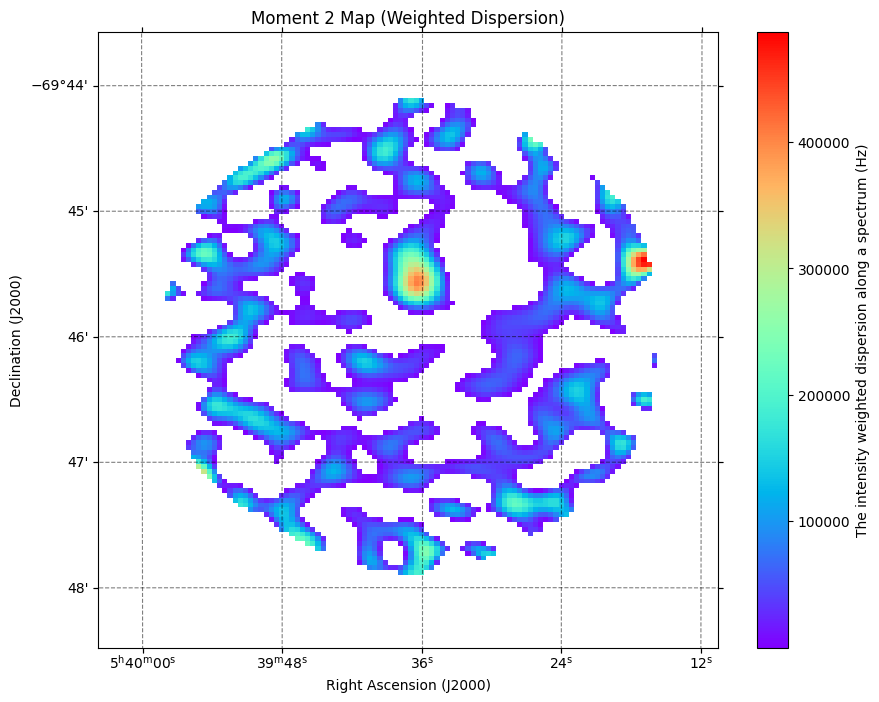

In [22]:
moment2 = Masked_Cube.moment(orde=2)

lwidth_sigma = Masked_Cube.linewidth_sigma()
lwidth_fwhm = Masked_Cube.linewidth_fwhm()


plt.plot(figsize=(18, 6))
plt.title("spectral-cube\nline width sigma", fontsize=14)
plt.imshow(lwidth_sigma.value, origin='lower')
plt.colorbar()

plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)  # Usar WCS para los ejes
im = ax.imshow(moment2.value, origin='lower', cmap='rainbow', aspect='auto')
plt.colorbar(im, label="The intensity weighted dispersion along a spectrum (Hz)")
ax.set_xlabel("Right Ascension (J2000)")
ax.set_ylabel("Declination (J2000)")
plt.title("Moment 2 Map (Weighted Dispersion)")
plt.grid(color='black', linestyle='--', alpha=0.5)
plt.show()

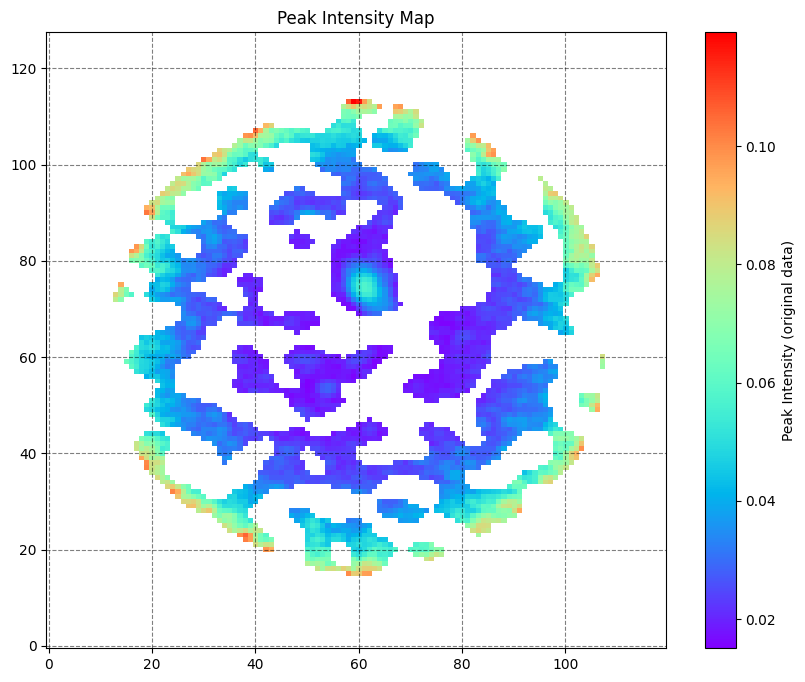

In [25]:
 ### Peak intensity  --- The peak intensity is simply the maximum along each spectrum
peak = Masked_Cube.max(axis=0)

plt.figure(figsize=(10, 8))
plt.title("Peak Intensity Map")
plt.imshow(peak.value, origin='lower', cmap='rainbow', aspect='auto')
plt.colorbar(label="Peak Intensity (original data)")
plt.grid(color='black', linestyle='--', alpha=0.5)
plt.show()


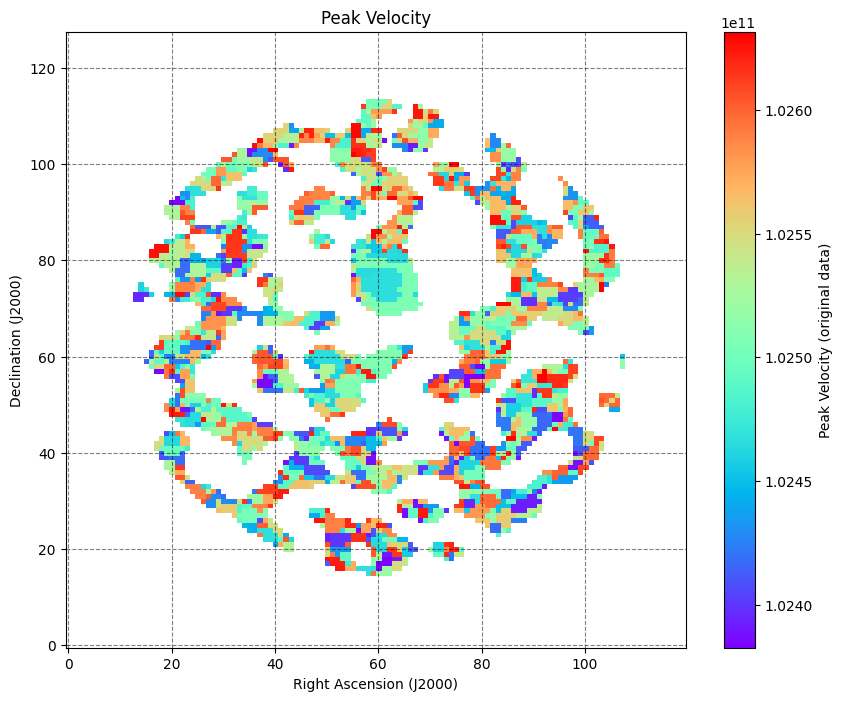

In [ ]:
#### Peak Velocity -----  The peak velocity is the velocity (or equivalent spectral unit) where the peak intensity is located.

plt.figure(figsize=(10, 8))
plt.title("Peak Velocity")
plt.imshow(peak_vel.value, origin='lower', cmap='rainbow', aspect='auto')
plt.colorbar(label="Peak Velocity (original data)")
plt.grid(color='black', linestyle='--', alpha=0.5)
plt.show()